# Consistency Training, but with JAX 🎆

JAX & Flax implementation of [Improved Consistency Training](https://arxiv.org/abs/2310.14189).
This code is partially based on [smsharma/consistency-models](https://github.com/smsharma/consistency-models/).

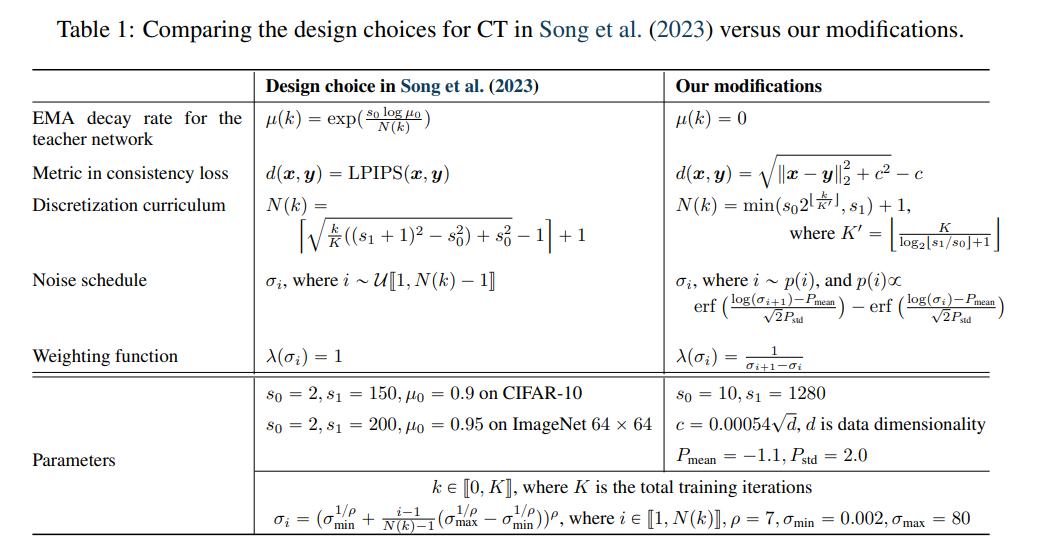

### Checklist

✅ Consistency loss (needs verification)

✅ Discretization curriculum

✖️ Noise schedule

✖️ Weighting function

✅ Parameters

In [1]:
%%capture
%pip install jax flax torch torchvision ipykernel

### 🚚 Imports

In [60]:
import jax
import einops
from jax import random
import jax.numpy as jnp
import jax.scipy as jsp
import flax.linen as nn
from flax.training.train_state import TrainState
from flax.jax_utils import replicate, unreplicate

import optax
import numpy as np
from optax.losses import l2_loss
from jax.tree_util import tree_map
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, default_collate
from torchvision.transforms import Compose, ToTensor, Lambda

from tqdm import trange
from functools import partial
from abc import abstractmethod
from dataclasses import dataclass
from typing import Optional, Sequence, Callable, Any

Shape = int | Sequence

## 🎲 Backbones

### MLP Mixer

In [61]:
class MLPBlock(nn.Module):
    mlp_dim: int

    @nn.compact
    def __call__(self, x):
        y = nn.Dense(self.mlp_dim)(x)
        y = nn.gelu(y)
        return nn.Dense(x.shape[-1])(y)


class MixerBlock(nn.Module):
    tokens_mlp_dim: int
    channels_mlp_dim: int

    @nn.compact
    def __call__(self, x):
        y = nn.LayerNorm()(x)
        y = jnp.swapaxes(y, 1, 2)
        y = MLPBlock(self.tokens_mlp_dim)(y)
        y = jnp.swapaxes(y, 1, 2)
        x = x + y
        y = nn.LayerNorm()(x)
        y = MLPBlock(self.channels_mlp_dim)(y)
        return x + y


class MLPMixer(nn.Module):
    patch_size: int
    num_blocks: int
    hidden_dim: int
    tokens_mlp_dim: int
    channels_mlp_dim: int
    num_classes: int

    @nn.compact
    def __call__(self, x, t, context):
        b, h, w, c = x.shape
        d_t_emb = t.shape[-1]

        context = nn.Embed(self.num_classes, t.shape[-1])(context)
        context = einops.repeat(context, "b t -> b (h p1) (w p2) t", h=h // self.patch_size, w=w // self.patch_size, p1=self.patch_size, p2=self.patch_size)

        t = einops.repeat(t, "b t -> b (h p1) (w p2) t", h=h // self.patch_size, w=w // self.patch_size, p1=self.patch_size, p2=self.patch_size)
        context = jnp.concatenate([context, t], axis=-1)

        context = nn.gelu(nn.Dense(self.tokens_mlp_dim)(context))
        context = nn.Dense(d_t_emb)(context)

        x = jnp.concatenate([x, context], axis=-1)

        x = nn.Conv(self.hidden_dim, [self.patch_size, self.patch_size], strides=[self.patch_size, self.patch_size])(x)
        x = einops.rearrange(x, "n h w c -> n (h w) c")

        for _ in range(self.num_blocks):
            x = MixerBlock(self.tokens_mlp_dim, self.channels_mlp_dim)(x)
        x = nn.LayerNorm()(x)

        x = nn.Dense(self.patch_size * self.patch_size * c)(x)
        x = einops.rearrange(x, "b (hp wp) (ph pw c) -> b (hp ph) (wp pw) c", hp=h // self.patch_size, wp=w // self.patch_size, ph=self.patch_size, pw=self.patch_size, c=c)

        return x

## ⚙️ Config

In [59]:
import os
import jax
import multiprocessing

# hardware = "tpu"
# hardware = "gpu"
hardware = "cpu"

if hardware == "tpu":
    pass # setup tpu

elif hardware == "gpu":
    pass # setup gpu

else:
    os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
        multiprocessing.cpu_count()
    )

    jax.config.update('jax_platform_name', 'cpu')

In [62]:
@dataclass
class ModelConfig:
    batch_size: int
    input_size: int
    channel_size: int
    time_embed_size: int
    max_time: float = 80.0
    s0: int = 10
    s1: int = 1280
    c=5.4e-4
    eps: float = 2e-3
    sigma: float = 0.5
    p_mean: float = -1.1
    p_std: float = 2.0
    dtype: Any = jnp.float32

    def __post_init__(self):
        self.c_data = self.c * self.input_size

    @abstractmethod
    def _create_backbone(self) -> nn.Module:
        pass


@dataclass
class MLPMixerConfig(ModelConfig):
    patch_size: int = 4
    num_blocks: int = 4
    hidden_dim: int = 256
    tokens_mlp_dim: int = 256
    channels_mlp_dim: int = 256
    num_classes: int = 10
    
    def _create_backbone(self):
        return MLPMixer(patch_size=self.patch_size,
                        num_blocks=self.num_blocks,
                        hidden_dim=self.hidden_dim,
                        tokens_mlp_dim=self.tokens_mlp_dim,
                        channels_mlp_dim=self.channels_mlp_dim,
                        num_classes=self.num_classes)

@dataclass
class TrainerConfig:
    lr: float = 3e-4

## ✨ Consistency Models

In [ ]:
def pseudo_huber_loss(x: jax.Array, y: jax.Array, c_data: float):
    loss = l2_loss(x, y)
    loss = jnp.sqrt(loss + c_data**2) - c_data
    return loss

In [63]:
def sinusoidal_embedding(time: jax.Array, embedding_size: int):
    time = time[..., 0]
    time = time * 1e3
    half_dim = embedding_size // 2
    emb_scale = jnp.log(1e4) / (half_dim - 1)
    
    emb = jnp.arange(half_dim) * -emb_scale
    emb = jnp.exp(emb)
    emb = emb[None, :] * time[:, None]

    sin_emb = jnp.sin(emb)
    cos_emb = jnp.cos(emb)
    embedding = jnp.concatenate([sin_emb, cos_emb], axis=-1)

    if embedding_size % 2 == 1:
        padding = ((0, 0), (0, 0), (0, 1))
        embedding = jnp.pad(embedding, padding, mode='constant')
    
    return embedding

In [64]:
class ConsistencyModel:
    def __init__(self, config: ModelConfig, key: jax.dtypes.prng_key):
        self.config = config
        self.random_key = key
        self.backbone = config._create_backbone()
    
    @staticmethod
    @partial(jax.jit, static_argnums=(2, 3))
    def consistency_fn(x: jax.Array,
                       t: float,
                       sigma: float,
                       eps: float):
        
        cskip = lambda t: (sigma ** 2 / ((t-eps)**2 + sigma ** 2))[:, :, None, None]
        cout = lambda t: (sigma * (t-eps) / jnp.sqrt(t**2 + sigma ** 2))[:, :, None, None]
        return x * cskip(t) + x * cout(t)
    
    def param_count(self):
        if self.train_state is None:
            raise "Model not initialized. Call `create_state` first to initialize."
        
        return sum(x.size for x in jax.tree_leaves(self.state.params))
    
    def discretize(self, sigma: float, eps: float, N: int):
        idx = jnp.arange(N)
        return (eps ** (1 / sigma) + idx / (N - 1) * (self.config.max_time ** (1 / sigma) - eps ** (1 / sigma))) ** sigma
    
    def get_boundaries(self, step: int):
        u = jnp.log(jnp.floor(self.config.s1 / self.config.s0)) + 1
        k_prime = jnp.floor(self.config.max_time / u)

        N = self.config.s0 * jnp.pow(2, jnp.floor(step / k_prime))
        N = min(self.config.s1, N)
        
        boundaries = self.discretize(self.config.sigma, self.config.eps, N)
        return boundaries, N.astype(jnp.int32)
    
    def create_state(self, key: jax.dtypes.prng_key, optimizer: Optional[Any] = None, keep_state: bool = True):
        noise_key, init_key = random.split(key)
        device_batch_size = self.config.batch_size// jax.device_count()
        init_shape = (device_batch_size,
                      self.config.input_size,
                      self.config.input_size,
                      self.config.channel_size)
        x = jax.random.normal(noise_key, init_shape)
        t = jnp.ones((device_batch_size, self.config.time_embed_size))
        
        y = jnp.ones((device_batch_size,)).astype(jnp.int32)
        params = self.backbone.init(init_key, x, t, y)
        train_state = TrainState.create(apply_fn=self.backbone.apply, params=params, tx=optimizer)

        if keep_state:
            self.state = train_state

In [65]:
@dataclass
class ConsistencyTrainer:
    model: ConsistencyModel
    dataloader: DataLoader
    config: TrainerConfig
    random_key: jax.dtypes.prng_key

    def __post_init__(self):
        if isinstance(self.dataloader, DataLoader):
            self.dataloader = iter(self.dataloader)

        self.random_key, init_key = jax.random.split(self.random_key)
        tx = optax.radam(learning_rate=self.config.lr)
        self.model.create_state(optimizer=tx, key=init_key)


    @staticmethod
    @partial(jax.jit, static_argnums=(1, 2, 6, 9, 10))
    def loss_fn(params, apply_fn, consistency_fn, x, t1, t2, time_embed_size, y, key, sigma, eps):
        z = jax.random.normal(key, shape=x.shape)

        x1 = x + z * t1[:, :, None, None]
        t1_emb = sinusoidal_embedding(t1, time_embed_size)

        x1 = apply_fn(params, x, t1_emb, y)
        x1 = consistency_fn(x1, t1, sigma, eps)

        x2 = x + z * t2[:, :, None, None]
        t2_emb = sinusoidal_embedding(t2, time_embed_size)
        x2 = apply_fn(params, x, t2_emb, y)
        x2 = consistency_fn(x2, t2, sigma, eps)

        return pseudo_huber_loss(x1, x2)

    @staticmethod
    @partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(5, 6, 7, 8, 9))
    def train_step(state, batch, t1, t2, key, consistency_fn, loss_fn, time_embed_size, sigma, eps):
        x, y = batch
        params = state.params
        apply_fn = state.apply_fn

        loss, grads = jax.value_and_grad(loss_fn)(params, apply_fn, consistency_fn, x, t1, t2, time_embed_size, y, key, sigma, eps)

        grads = jax.lax.pmean(grads, "batch")
        loss = jax.lax.pmean(loss, "batch")

        state = state.apply_gradients(grads=grads)
        return state, loss

    def train(self, timesteps: int):
        state = replicate(self.model.state)
        batch_size = self.model.config.batch_size
        num_devices = jax.device_count()
        device_batch_size = batch_size // num_devices

        assert batch_size % num_devices == 0, f"Batch size must be divisible by the number of devices, but got {batch_size} and {num_devices}."
        
        with trange(timesteps) as steps:
            for step in steps:
                batch = next(self.dataloader)
                x_batch, y_batch = batch

                b, h, w, c = x_batch.shape
                x_batch = x_batch.reshape(num_devices, device_batch_size, h, w, c)
                y_batch = y_batch.reshape(num_devices, device_batch_size)

                sigma = self.model.config.sigma
                eps = self.model.config.eps
                self.random_key, time_key = random.split(self.random_key)
                self.random_key, *train_keys = random.split(self.random_key, min(x_batch.shape[0], jax.local_device_count()) + 1)

                boundaries, N = self.model.get_boundaries(step)
                n_batch = jax.random.randint(time_key, minval=0, maxval=N - 1, shape=(*x_batch.shape[:2], 1))

                t1, t2 = boundaries[n_batch], boundaries[n_batch + 1]
                
                state, loss = self.train_step(state,
                                              (x_batch, y_batch),
                                              t1, t2,
                                              jnp.asarray(train_keys),
                                              self.model.consistency_fn,
                                              self.loss_fn,
                                              self.model.config.time_embed_size,
                                              sigma, eps)
                
                steps.set_postfix(val=unreplicate(loss))
                
        self.model.state = unreplicate(state)

## 🏋️ Training

In [ ]:
random_key = random.key(0)
random_key, model_key, trainer_key = random.split(random_key, 3)

model_config = MLPMixerConfig(batch_size=256,
                        input_size=28, 
                        channel_size=1,
                        time_embed_size=16)

model = ConsistencyModel(model_config, model_key)

def numpy_collate(batch):
    batch = default_collate(batch)
    batch = tree_map(lambda x: np.asarray(x), batch)
    return batch

from torchvision.transforms import Compose, ToTensor, Lambda

transform = Compose([
    ToTensor(),
    Lambda(lambda x: x.permute(1, 2, 0)),
    Lambda(lambda x: x * 2 - 1),
])


mnist_dataset = MNIST('/tmp/mnist', download=True, transform=transform)

dataloader = DataLoader(dataset=mnist_dataset,
                         batch_size=model_config.batch_size,
                         shuffle=True,
                         collate_fn=numpy_collate,
                         drop_last=True)

trainer = ConsistencyTrainer(model=model,
                             dataloader=dataloader,
                             config=TrainerConfig(),
                             random_key=trainer_key)

trainer.train(timesteps=int(1e4))